In [87]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/kavsir_bboxes.json
/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/images/cju7d1tvt25bu08019dvw3uff.jpg
/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/images/cju30qbm1ad3x0855znuhpz9u.jpg
/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/images/cju5xq3tdm9fn0987pbedxdg5.jpg
/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/images/cju7deifq2fzn0755lc8idyh8.jpg
/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/images/cju2raxlosl630988jdbfy9b0.jpg
/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/images/cju5uget8krjy0818kvywd0zu.jpg
/kaggle/input/kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/images/cju8b1v3br45u087189kku66u.jpg
/kaggle/input/kvasir-datas

In [88]:
import os
import numpy as np
import cv2
import os
from glob import glob 
from tensorflow.keras.utils import Sequence
from sklearn.metrics import confusion_matrix, jaccard_score
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input, LayerNormalization, MultiHeadAttention, Dense, Reshape

In [89]:
orgpath = '/kaggle/input/kvasir-dataset-for-classification-and-segmentation/'
FOLDER_PATH = orgpath + 'kvasir-seg/'
image_size = 256
batch_size = 8
epochs = 50


train_path = FOLDER_PATH + "Kvasir-SEG/"
validation_path = FOLDER_PATH + "Kvasir-SEG/"
test_path = FOLDER_PATH + "Kvasir-SEG/"

In [90]:
class DataGen(Sequence):
    def __init__(self, ids, path, batch_size=2, image_size=256, **kwargs):
        super().__init__(**kwargs)  # Call the superclass constructor
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()


    def __load__(self, id_name):
        image_path = os.path.join(self.path, "images",id_name)
        mask_path = os.path.join(self.path, "masks", id_name)
        image = cv2.imread(image_path)
        if image is None or image.size == 0:
            return None, None
        image = cv2.resize(image, (self.image_size, self.image_size)) / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None or mask.size == 0:
            return None, None
        mask = cv2.resize(mask, (self.image_size, self.image_size)) / 255.0
        mask = np.expand_dims(mask, axis=-1)

        return image, mask

    def __getitem__(self, index):
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        images, masks = [], []
        for id_name in files_batch:
            img, msk = self.__load__(id_name)
            if img is not None and msk is not None:
                images.append(img)
                masks.append(msk)
        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        np.random.shuffle(self.ids)

    def __len__(self):
        return int(np.ceil(len(self.ids) / float(self.batch_size)))

In [91]:
def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def F1(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    dice = K.mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice

def dice_coef(y_true, y_pred, smooth = 0.00001):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def dice_loss(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

#till here it is mostly redundant, below is real code but like i said, keep.
def load_test_data(batch_size=10):
    test_ids = os.listdir(os.path.join(test_path, "images"))
    gen = DataGen(test_ids, test_path, batch_size=batch_size, image_size=image_size)
    print("Test Data Loaded")
    return gen, len(test_ids)

def scheduler(epoch, lr):
    if epoch < 30:
        lr = 0.001
        return lr
    if epoch < 50:
        return 0.0005
    return 0.0001

def visualize_output(x, y, y_pred, tot, idx, fig, title_flag=False):
    contours1, hierarchy = cv2.findContours(y[0].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours2, hierarchy = cv2.findContours(y_pred[0].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(x[0], contours1, -1, (0, 255, 0), 3)
    cv2.drawContours(x[0], contours2, -1, (255, 0, 0), 3)
    ax = fig.add_subplot(tot, 5, idx)
    ax.imshow(np.reshape(x[0], (image_size, image_size, 3)))

def evaluate_model(gen, model):
    results = {}
    y_true_all = []
    y_pred_all = []
    num_tests = len(gen)
    for i in range(num_tests):
        x, y_true = gen[i]
        y_pred_prob = model.predict(x)
        y_pred = (y_pred_prob > 0.8).astype(int)
        y_true = (y_true > 0.5).astype(int)
        y_true_all.extend(y_true.flatten())
        y_pred_all.extend(y_pred.flatten())
    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)
    tn, fp, fn, tp = confusion_matrix(y_true_all, y_pred_all).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    iou = jaccard_score(y_true_all, y_pred_all)
    out = model.evaluate(gen, steps=num_tests)
    last_metric = out[-1]
    results = {
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'IoU': iou,
        'Eval Metric': last_metric
    }
    print(results)

In [92]:
#  import tensorflow as tf
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, LayerNormalization, Dense, MultiHeadAttention
# from tensorflow.keras.models import Model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Define the Transformer block
# def vision_mamba_transformer_block(x, num_heads, embed_dim):
#     # Layer Normalization
#     x_norm = LayerNormalization(epsilon=1e-6)(x)
    
#     # Multi-Head Attention
#     attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x_norm, x_norm)
#     attn_output = x + attn_output  # Residual connection
    
#     # Feed-Forward Network
#     x_norm = LayerNormalization(epsilon=1e-6)(attn_output)
#     ffn_output = Dense(embed_dim, activation='relu')(x_norm)
#     ffn_output = Dense(embed_dim)(ffn_output)
    
#     # Residual connection
#     return attn_output + ffn_output

# # Input layer
# inputs = Input(shape=(256, 256, 3))

# # Encoder
# c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
# c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
# p1 = MaxPooling2D((2, 2))(c1)

# c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
# c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
# p2 = MaxPooling2D((2, 2))(c2)

# c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
# c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
# p3 = MaxPooling2D((2, 2))(c3)

# c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
# c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
# p4 = MaxPooling2D((2, 2))(c4)

# # Bottleneck with Transformer block
# bn = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
# bn = vision_mamba_transformer_block(bn, num_heads=8, embed_dim=1024)
# bn = Conv2D(1024, (3, 3), activation='relu', padding='same')(bn)

# # Decoder
# u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn)
# u6 = concatenate([u6, c4])
# c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
# c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

# u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
# u7 = concatenate([u7, c3])
# c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
# c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

# u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
# u8 = concatenate([u8, c2])
# c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
# c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

# u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
# u9 = concatenate([u9, c1])
# c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
# c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

# # Output layer
# outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

# # Compile the model
# model = Model(inputs=[inputs], outputs=[outputs])
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# # Print the model summary
# model.summary()


In [93]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, GlobalAveragePooling2D, Dense, Reshape, Multiply, Activation
# from tensorflow.keras.models import Model

# # Define the SE Block
# def squeeze_excite_block(input_tensor, ratio=16):
#     init = input_tensor
#     filters = init.shape[-1]  # Number of input channels
    
#     # Squeeze operation
#     se = GlobalAveragePooling2D()(init)
#     se = Dense(filters // ratio, activation='relu')(se)
#     se = Dense(filters, activation='sigmoid')(se)
#     se = Reshape((1, 1, filters))(se)
    
#     # Excite operation: scale feature maps
#     x = Multiply()([init, se])
#     return x

# # Input layer
# inputs = Input(shape=(256, 256, 3))

# # Encoder with SE blocks
# c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
# c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
# c1 = squeeze_excite_block(c1)
# p1 = MaxPooling2D((2, 2))(c1)

# c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
# c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
# c2 = squeeze_excite_block(c2)
# p2 = MaxPooling2D((2, 2))(c2)

# c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
# c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
# c3 = squeeze_excite_block(c3)
# p3 = MaxPooling2D((2, 2))(c3)

# c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
# c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
# c4 = squeeze_excite_block(c4)
# p4 = MaxPooling2D((2, 2))(c4)

# # Bottleneck with SE block
# bn = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
# bn = squeeze_excite_block(bn)
# bn = Conv2D(1024, (3, 3), activation='relu', padding='same')(bn)

# # Decoder with SE blocks
# u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn)
# u6 = concatenate([u6, c4])
# c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
# c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
# c6 = squeeze_excite_block(c6)

# u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
# u7 = concatenate([u7, c3])
# c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
# c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
# c7 = squeeze_excite_block(c7)

# u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
# u8 = concatenate([u8, c2])
# c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
# c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
# c8 = squeeze_excite_block(c8)

# u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
# u9 = concatenate([u9, c1])
# c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
# c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
# c9 = squeeze_excite_block(c9)

# # Output layer
# outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

# # Compile the model
# model = Model(inputs=[inputs], outputs=[outputs])
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# # Print the model summary
# model.summary()

In [94]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Reshape, Multiply, Activation, Add, Lambda
from tensorflow.keras.layers import BatchNormalization, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Define the SE Block
def squeeze_excite_block(input_tensor, ratio=16):
    init = input_tensor
    filters = init.shape[-1]  # Number of input channels
    
    # Squeeze operation
    se = GlobalAveragePooling2D()(init)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, 1, filters))(se)
    
    # Excite operation: scale feature maps
    x = Multiply()([init, se])
    return x

# Define the Channel Attention (CA) module for CBAM
def channel_attention(input_tensor, ratio=8):
    channel = input_tensor.shape[-1]
    
    # Squeeze and Excitation by Global Pooling
    shared_dense_one = Dense(channel // ratio, activation='relu', use_bias=True)
    shared_dense_two = Dense(channel, use_bias=True)

    avg_pool = GlobalAveragePooling2D()(input_tensor)
    avg_pool = shared_dense_one(avg_pool)
    avg_pool = shared_dense_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_tensor)
    max_pool = shared_dense_one(max_pool)
    max_pool = shared_dense_two(max_pool)

    # Combine the outputs of both pooling layers
    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    cbam_feature = Reshape((1, 1, channel))(cbam_feature)

    # Scale the input tensor with channel attention
    x = Multiply()([input_tensor, cbam_feature])
    return x

# Define the Spatial Attention (SA) module for CBAM
def spatial_attention(input_tensor):
    avg_pool = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(input_tensor)
    max_pool = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(input_tensor)
    concat = concatenate([avg_pool, max_pool], axis=-1)

    # Convolution for spatial attention
    cbam_feature = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)

    # Scale the input tensor with spatial attention
    x = Multiply()([input_tensor, cbam_feature])
    return x

# Define the CBAM Block
def cbam_block(input_tensor, ratio=8):
    x = channel_attention(input_tensor, ratio)
    x = spatial_attention(x)
    return x

# Combined SE and CBAM Block
def se_cbam_block(input_tensor, se_ratio=16, cbam_ratio=8):
    # Apply SE block first
    x = squeeze_excite_block(input_tensor, se_ratio)
    # Apply CBAM block next
    x = cbam_block(x, cbam_ratio)
    return x

# Input layer
inputs = Input(shape=(256, 256, 3))

# Encoder with SE + CBAM blocks
c1 = Conv2D(64, (3, 3), padding='same')(inputs)
c1 = BatchNormalization()(c1)
c1 = ReLU()(c1)
c1 = Conv2D(64, (3, 3), padding='same')(c1)
c1 = BatchNormalization()(c1)
c1 = ReLU()(c1)
c1 = se_cbam_block(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(128, (3, 3), padding='same')(p1)
c2 = BatchNormalization()(c2)
c2 = ReLU()(c2)
c2 = Conv2D(128, (3, 3), padding='same')(c2)
c2 = BatchNormalization()(c2)
c2 = ReLU()(c2)
c2 = se_cbam_block(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(256, (3, 3), padding='same')(p2)
c3 = BatchNormalization()(c3)
c3 = ReLU()(c3)
c3 = Conv2D(256, (3, 3), padding='same')(c3)
c3 = BatchNormalization()(c3)
c3 = ReLU()(c3)
c3 = se_cbam_block(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(512, (3, 3), padding='same')(p3)
c4 = BatchNormalization()(c4)
c4 = ReLU()(c4)
c4 = Conv2D(512, (3, 3), padding='same')(c4)
c4 = BatchNormalization()(c4)
c4 = ReLU()(c4)
c4 = se_cbam_block(c4)
p4 = MaxPooling2D((2, 2))(c4)

# Bottleneck with SE + CBAM block
bn = Conv2D(1024, (3, 3), padding='same')(p4)
bn = BatchNormalization()(bn)
bn = ReLU()(bn)
bn = se_cbam_block(bn)
bn = Conv2D(1024, (3, 3), padding='same')(bn)
bn = BatchNormalization()(bn)
bn = ReLU()(bn)

# Decoder with SE + CBAM blocks
u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn)
u6 = concatenate([u6, c4])
c6 = Conv2D(512, (3, 3), padding='same')(u6)
c6 = BatchNormalization()(c6)
c6 = ReLU()(c6)
c6 = Conv2D(512, (3, 3), padding='same')(c6)
c6 = BatchNormalization()(c6)
c6 = ReLU()(c6)
c6 = se_cbam_block(c6)

u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(256, (3, 3), padding='same')(u7)
c7 = BatchNormalization()(c7)
c7 = ReLU()(c7)
c7 = Conv2D(256, (3, 3), padding='same')(c7)
c7 = BatchNormalization()(c7)
c7 = ReLU()(c7)
c7 = se_cbam_block(c7)

u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(128, (3, 3), padding='same')(u8)
c8 = BatchNormalization()(c8)
c8 = ReLU()(c8)
c8 = Conv2D(128, (3, 3), padding='same')(c8)
c8 = BatchNormalization()(c8)
c8 = ReLU()(c8)
c8 = se_cbam_block(c8)

u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1])
c9 = Conv2D(64, (3, 3), padding='same')(u9)
c9 = BatchNormalization()(c9)
c9 = ReLU()(c9)
c9 = Conv2D(64, (3, 3), padding='same')(c9)
c9 = BatchNormalization()(c9)
c9 = ReLU()(c9)
c9 = se_cbam_block(c9)

# Output layer
outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

# Compile the model
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_160 (Conv2D) │ (None, 256, 256,  │      1,792 │ input_layer_7[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_160[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_54 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_161 (Conv2D) │ (None, 256, 256,  │     36,928 │ re_lu_54[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_161[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_55 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ re_lu_55[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_112 (Dense)   │ (None, 4)         │        260 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_113 (Dense)   │ (None, 64)        │        320 │ dense_112[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_54          │ (None, 1, 1, 64)  │          0 │ dense_113[0][0]   │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_81         │ (None, 256, 256,  │          0 │ re_lu_55[0][0],   │
│ (Multiply)          │ 64)               │            │ reshape_54[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ multiply_81[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ multiply_81[0][0] │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_114 (Dense)   │ (None, 8)         │        520 │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_115 (Dense)   │ (None, 64)        │        576 │ dense_114[0][0],  │
│                     │                   │            │ dense_114[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_31 (Add)        │ (None, 64)        │          0 │ dense_115[0][0],  │
│                     │                   │            │ dense_115[1][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 31,716,964 (120.99 MB)

 Trainable params: 31,705,188 (120.95 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [95]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Reshape, Multiply, Activation, Add, Lambda
# from tensorflow.keras.layers import BatchNormalization, ReLU
# from tensorflow.keras.models import Model
# from tensorflow.keras import backend as K

# # Define the Channel Attention (CA) module
# def channel_attention(input_tensor, ratio=8):
#     channel = input_tensor.shape[-1]
    
#     # Squeeze and Excitation by Global Pooling
#     shared_dense_one = Dense(channel // ratio, activation='relu', use_bias=True)
#     shared_dense_two = Dense(channel, use_bias=True)

#     avg_pool = GlobalAveragePooling2D()(input_tensor)
#     avg_pool = shared_dense_one(avg_pool)
#     avg_pool = shared_dense_two(avg_pool)

#     max_pool = GlobalMaxPooling2D()(input_tensor)
#     max_pool = shared_dense_one(max_pool)
#     max_pool = shared_dense_two(max_pool)

#     # Combine the outputs of both pooling layers
#     cbam_feature = Add()([avg_pool, max_pool])
#     cbam_feature = Activation('sigmoid')(cbam_feature)
#     cbam_feature = Reshape((1, 1, channel))(cbam_feature)

#     # Scale the input tensor with channel attention
#     x = Multiply()([input_tensor, cbam_feature])
#     return x

# # Define the Spatial Attention (SA) module
# def spatial_attention(input_tensor):
#     avg_pool = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(input_tensor)
#     max_pool = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(input_tensor)
#     concat = concatenate([avg_pool, max_pool], axis=-1)

#     # Convolution for spatial attention
#     cbam_feature = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)

#     # Scale the input tensor with spatial attention
#     x = Multiply()([input_tensor, cbam_feature])
#     return x

# # Define the CBAM Block
# def cbam_block(input_tensor, ratio=8):
#     x = channel_attention(input_tensor, ratio)
#     x = spatial_attention(x)
#     return x

# # Input layer
# inputs = Input(shape=(256, 256, 3))

# # Encoder with CBAM blocks
# c1 = Conv2D(64, (3, 3), padding='same')(inputs)
# c1 = BatchNormalization()(c1)
# c1 = ReLU()(c1)
# c1 = Conv2D(64, (3, 3), padding='same')(c1)
# c1 = BatchNormalization()(c1)
# c1 = ReLU()(c1)
# c1 = cbam_block(c1)
# p1 = MaxPooling2D((2, 2))(c1)

# c2 = Conv2D(128, (3, 3), padding='same')(p1)
# c2 = BatchNormalization()(c2)
# c2 = ReLU()(c2)
# c2 = Conv2D(128, (3, 3), padding='same')(c2)
# c2 = BatchNormalization()(c2)
# c2 = ReLU()(c2)
# c2 = cbam_block(c2)
# p2 = MaxPooling2D((2, 2))(c2)

# c3 = Conv2D(256, (3, 3), padding='same')(p2)
# c3 = BatchNormalization()(c3)
# c3 = ReLU()(c3)
# c3 = Conv2D(256, (3, 3), padding='same')(c3)
# c3 = BatchNormalization()(c3)
# c3 = ReLU()(c3)
# c3 = cbam_block(c3)
# p3 = MaxPooling2D((2, 2))(c3)

# c4 = Conv2D(512, (3, 3), padding='same')(p3)
# c4 = BatchNormalization()(c4)
# c4 = ReLU()(c4)
# c4 = Conv2D(512, (3, 3), padding='same')(c4)
# c4 = BatchNormalization()(c4)
# c4 = ReLU()(c4)
# c4 = cbam_block(c4)
# p4 = MaxPooling2D((2, 2))(c4)

# # Bottleneck with CBAM block
# bn = Conv2D(1024, (3, 3), padding='same')(p4)
# bn = BatchNormalization()(bn)
# bn = ReLU()(bn)
# bn = cbam_block(bn)
# bn = Conv2D(1024, (3, 3), padding='same')(bn)
# bn = BatchNormalization()(bn)
# bn = ReLU()(bn)

# # Decoder with CBAM blocks
# u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn)
# u6 = concatenate([u6, c4])
# c6 = Conv2D(512, (3, 3), padding='same')(u6)
# c6 = BatchNormalization()(c6)
# c6 = ReLU()(c6)
# c6 = Conv2D(512, (3, 3), padding='same')(c6)
# c6 = BatchNormalization()(c6)
# c6 = ReLU()(c6)
# c6 = cbam_block(c6)

# u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
# u7 = concatenate([u7, c3])
# c7 = Conv2D(256, (3, 3), padding='same')(u7)
# c7 = BatchNormalization()(c7)
# c7 = ReLU()(c7)
# c7 = Conv2D(256, (3, 3), padding='same')(c7)
# c7 = BatchNormalization()(c7)
# c7 = ReLU()(c7)
# c7 = cbam_block(c7)

# u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
# u8 = concatenate([u8, c2])
# c8 = Conv2D(128, (3, 3), padding='same')(u8)
# c8 = BatchNormalization()(c8)
# c8 = ReLU()(c8)
# c8 = Conv2D(128, (3, 3), padding='same')(c8)
# c8 = BatchNormalization()(c8)
# c8 = ReLU()(c8)
# c8 = cbam_block(c8)

# u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
# u9 = concatenate([u9, c1])
# c9 = Conv2D(64, (3, 3), padding='same')(u9)
# c9 = BatchNormalization()(c9)
# c9 = ReLU()(c9)
# c9 = Conv2D(64, (3, 3), padding='same')(c9)
# c9 = BatchNormalization()(c9)
# c9 = ReLU()(c9)
# c9 = cbam_block(c9)

# # Output layer
# outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

# # Compile the model
# model = Model(inputs=[inputs], outputs=[outputs])
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# # Print the model summary
# model.summary()


In [96]:
# Load training and validation data
train_ids = os.listdir(os.path.join(train_path, "images"))  #keeep track. do not fuck up directory structure
val_ids = os.listdir(os.path.join(validation_path, "images"))

train_gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
val_gen = DataGen(val_ids, validation_path, batch_size=batch_size, image_size=image_size)

# Callbacks
checkpoint = ModelCheckpoint('vmunet_bus_se.keras', save_best_only=True, monitor='val_loss', mode='min')  #Change model name
lr_scheduler = LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[checkpoint, lr_scheduler, reduce_lr]
)

model.save('/kaggle/working/vmunet_bus_se.keras') #change model name
print("Model saved successfully!")

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 84s 365ms/step - accuracy: 0.8003 - loss: 0.5116 - val_accuracy: 0.8401 - val_loss: 0.5205 - learning_rate: 0.0010
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 327ms/step - accuracy: 0.8455 - loss: 0.3270 - val_accuracy: 0.8400 - val_loss: 0.4491 - learning_rate: 0.0010
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 312ms/step - accuracy: 0.8595 - loss: 0.2976 - val_accuracy: 0.8467 - val_loss: 0.6169 - learning_rate: 0.0010
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 328ms/step - accuracy: 0.8755 - loss: 0.2762 - val_accuracy: 0.8819 - val_loss: 0.2727 - learning_rate: 0.0010
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 314ms/step - accuracy: 0.8814 - loss: 0.2655 - val_accuracy: 0.6955 - val_loss: 0.7515 - learning_rate: 0.0010
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 314ms/step - accuracy: 0.8907 - loss: 0.2513 - val_accuracy: 0.8533 - val_loss: 0.3386 - learning_rate: 0.0010
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 314ms/step - accuracy: 0.8

125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.9741 - loss: 0.0430
Validation Loss: 0.044508662074804306
Validation Accuracy: 0.9735106229782104
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


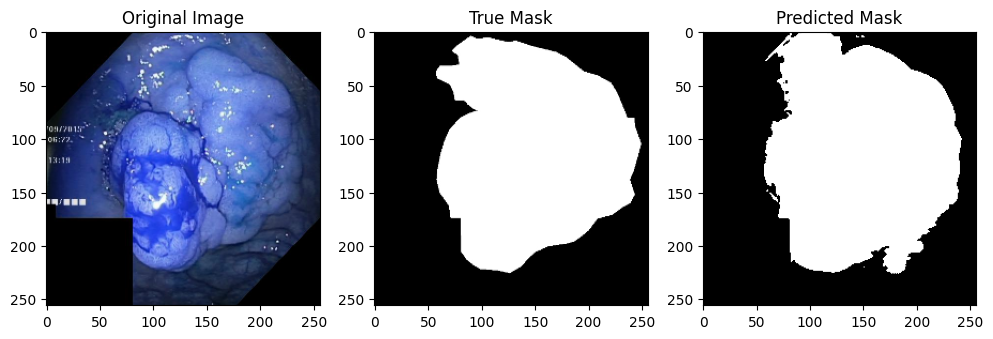

Image 1 - Accuracy: 0.9769, Precision: 0.9573, IoU: 0.9316
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


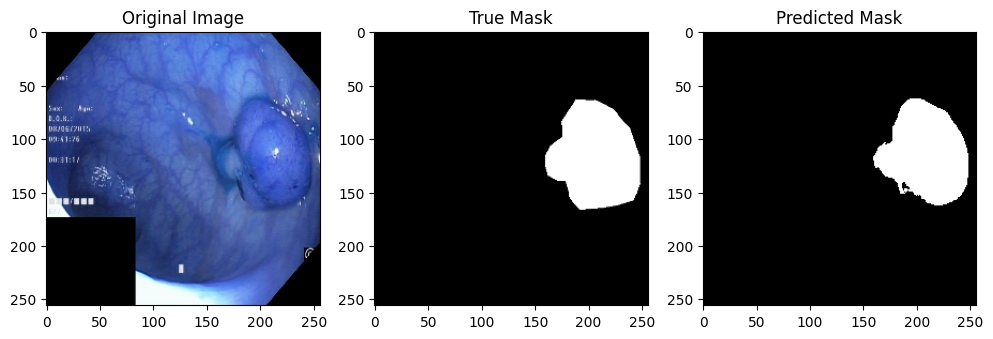

Image 2 - Accuracy: 0.9761, Precision: 0.9235, IoU: 0.9257
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


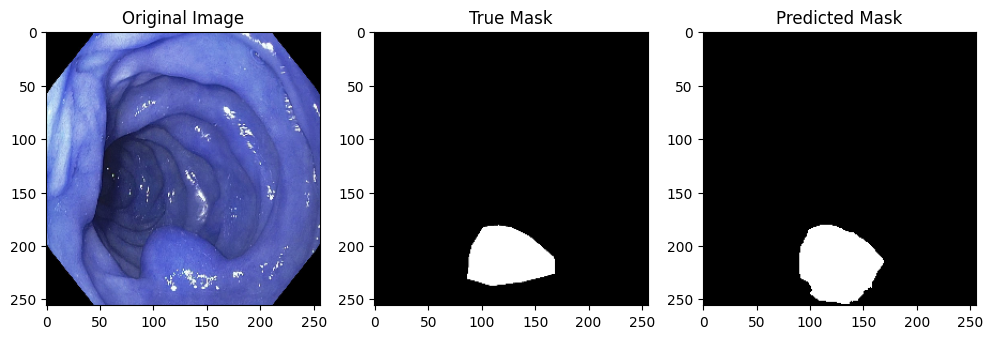

Image 3 - Accuracy: 0.9710, Precision: 0.8767, IoU: 0.9019


In [97]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import MeanIoU, Precision
from sklearn.metrics import accuracy_score

# Evaluate the model on the validation set
results = model.evaluate(val_gen)
print("Validation Loss:", results[0])
print("Validation Accuracy:", results[1])

# Define function to calculate IoU for each image in the batch
def calculate_iou(y_true, y_pred, num_classes=2):
    iou_metric = MeanIoU(num_classes=num_classes)
    iou_metric.update_state(y_true, y_pred)
    return iou_metric.result().numpy()

# Function to display original image, ground truth mask, and predicted mask
def display_predictions(model, generator, num_images=3):
    for i in range(num_images):
        # Get a batch of images and masks
        img, true_mask = generator[i]
        
        # Predict the mask for the image
        pred_mask = model.predict(img)
        
        # Threshold the predicted mask to binary and convert to integer type
        pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)
        true_mask_int = (true_mask > 0.5).astype(np.uint8)  # Ensure true_mask is also binary

        # Display the original image, true mask, and predicted mask
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(img[0])
        
        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(true_mask[0].squeeze(), cmap='gray')
        
        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask_bin[0].squeeze(), cmap='gray')
        
        plt.show()
        
        # Calculate metrics
        accuracy = accuracy_score(true_mask_int.flatten(), pred_mask_bin.flatten())
        precision = Precision()
        precision.update_state(true_mask_int, pred_mask_bin)
        
        iou = calculate_iou(true_mask_int, pred_mask_bin)
        
        print(f"Image {i+1} - Accuracy: {accuracy:.4f}, Precision: {precision.result().numpy():.4f}, IoU: {iou:.4f}")

# Display predictions and metrics
display_predictions(model, val_gen, num_images=3)


In [98]:
def visualize_output(x, y, y_pred, tot, idx, fig, title_flag=False):
    contours1, hierarchy = cv2.findContours(y[0].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours2, hierarchy = cv2.findContours(y_pred[0].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(x[0], contours1, -1, (0, 255, 0), 3)
    cv2.drawContours(x[0], contours2, -1, (255, 0, 0), 3)
    ax = fig.add_subplot(tot, 5, idx)
    ax.imshow(np.reshape(x[0], (image_size, image_size, 3)))

def evaluate_model(gen, model):
    results = {}
    y_true_all = []
    y_pred_all = []
    num_tests = len(gen)
    for i in range(num_tests):
        x, y_true = gen[i]
        y_pred_prob = model.predict(x)
        y_pred = (y_pred_prob > 0.8).astype(int)
        y_true = (y_true > 0.5).astype(int)
        y_true_all.extend(y_true.flatten())
        y_pred_all.extend(y_pred.flatten())
    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)
    tn, fp, fn, tp = confusion_matrix(y_true_all, y_pred_all).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    iou = jaccard_score(y_true_all, y_pred_all)
    out = model.evaluate(gen, steps=num_tests)
    last_metric = out[-1]
    results = {
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'IoU': iou,
        'Eval Metric': last_metric
    }
    print(results)